# Tutorial：3
- 使用フレームワーク : deap
- 選択手法 : NSGA-Ⅲ
- 設計変数 : 5個
  - 連続値 : 3個
  - 離散値 : 2個
- 目的変数 : 2個
- 制約条件 : 3パターン
    1. 連続値のmin,max
    2. 離散値の取り得るパターン
    3. 変数間の組み合わせに制約あり

## 習得してもらうこと
- 変数間の組み合わせに制約がある場合の扱い方

## 実施内容
 - Part0. 取り扱う問題設定

 - Patr1: モジュールのimport 

 - Part2: 評価関数の作成
   - 目的関数の設計
   - ペナルティ関数の導入


 - Part3: 遺伝的アルゴリズムの設計
   - 遺伝的アルゴリズムにおける個体の表現
   - 遺伝子操作関数の設定
     - 交叉
     - 突然変異
   - 解の選択手法の設定


 - Part4: 最適化計算の実行
   - 初期状態の設定
   - 遺伝的最適化計算の実行  


 - Part5. 結果の確認
   - 初期世代と最終世代の目的関数の値を確認
   - 制約条件を満たした値であるか確認
   - ハイパーボリューム

# Part0. 取り扱う問題設定

$
\begin{align*}
&\text{Minimize}& f_1 & = 4A^2 + 4B^2 + X^2 + Y + Z\\
&\text{Minimize}& f_2 & = (A - 5)^2 + (B - 5)^2 + X - 4(Y+5)^2 - Z
\end{align*}
$

$ 
\begin{align*}
&s.t.& 0 \leqq  & A  \leqq 5 \\
& & 0 \leqq  & B  \leqq 3 \\
& &X \in&  \{ 0,1 \} \\
& &Y \in&  \{ -2,-1,0,1 \} \\
& &Z \in&  \{0,1\}\\
& &(X,Y) \in&  \{(0,-2), (0,-1), (1, 0),(1,1)\}
\end{align*}
$

# Part1. モジュールのimport

In [1]:
%load_ext lab_black

In [2]:
import itertools
import random
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from deap import base, creator, tools
from deap.algorithms import varAnd
from deap.benchmarks.tools import hypervolume

# Part2. 評価関数の作成

### 目的関数
- 今回は5つの設計変数A, B, X, Y, Zを使って目的変数のf1, f2 を多目的最適化する

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 + X^2 + Y +Z\\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2 + X - 4(Y+5)^2-Z
\end{align*}
$

In [3]:
def objectfunction(individual):
    """
    individual(list): 個体の設計変数を格納するlist
    """

    # 教材用としてわかりやすくするために、変数を作成
    A = individual[0]
    B = individual[1]
    X = individual[2]
    Y = individual[3]
    Z = individual[4]

    f1 = 4 * A ** 2 + 4 * B ** 2 + X ** 2 + Y + Z
    f2 = (A - 5) ** 2 + (B - 5) ** 2 + X + 4 * (Y + 5) ** 2 - Z

    return f1, f2

### ペナルティ関数

##### 変数間の組合せパターンに関する制約が追加されております

$ 
\begin{align*}
&s.t.& 0 \leqq  & A  \leqq 5 \\
& & 0 \leqq  & B  \leqq 3 \\
& &X \in&  \{ 0,1 \} \\
& &Y \in&  \{ -2,-1,0,1 \} \\
& &Z \in&  \{0,1\}\\
& &(X,Y) \in&  \{(0,-2), (0,-1), (1, 0),(1,1)\}
\end{align*}
$

In [4]:
# ペナルティ関数で判定したい制約条件のリスト
# 教材用にこちらで定義しているが、後ほど登場する「generator_config」から作れるようにした方が良い
cases = [
    {"type": "minmax", "case": {0: {"min": 0, "max": 5}, 1: {"min": 0, "max": 3}}},
    {"type": "pattern", "case": {4: {"values": [0, 1]}}},
    {
        "type": "pattern_comb",
        "case": {(2, 3): {"choices": [(0, -2), (0, -1), (1, 0), (1, 1)]}},
    },
]

#### 複数変数のパターン組み合わせに関する制約を満たしているかをjudge_pattern_combという関数でチェックする

In [5]:
# ペナルティ関数で使用する関数
# 可能範囲以内(連続値)
def judge_minmax(individual, case):
    """
    individual(list): 個体の設計変数を格納するlist
    cases(list): 判定したい条件のlist(各要素はdict型)
    """
    for k, v in case.items():
        if not float(v["min"]) <= individual[int(k)] <= v["max"]:
            return False
    return True


# 可能範囲以内（離散値）
def judge_pattern(individual, case):
    for k, v in case.items():
        if not individual[int(k)] in v["values"]:
            return False
    return True


# 複数変数のパターン制約
def judge_pattern_comb(individual, case):
    for (k, l), v in case.items():
        if not (individual[int(k)], individual[int(l)]) in v["choices"]:
            return False
    return True


# ペナルティ関数用の条件判定関数 - 他の条件が出来た時にfor文内に追記することで対応可
def judge(individual, cases):
    for case in cases:
        if case["type"] == "minmax":
            if not judge_minmax(individual, case["case"]):
                return False
        if case["type"] == "pattern":
            if not judge_pattern(individual, case["case"]):
                return False
        if case["type"] == "pattern_comb":
            if not judge_pattern_comb(individual, case["case"]):
                return False
    return True

#### 評価関数&ペナルティ関数の導入

In [6]:
# ペナルティ関数の罰則値(適応度)
distance = (1000, 1000)

# 評価関数を作成
toolbox = base.Toolbox()
toolbox.register("evaluate", objectfunction)
toolbox.register("feasible", judge, cases=cases)
toolbox.decorate("evaluate", tools.DeltaPenality(toolbox.feasible, delta=distance))

# Part.3 遺伝的アルゴリズムの設計

## 遺伝的アルゴリズムにおける個体の表現

In [7]:
# 適合度を最小化することで最適化されるような適合度クラスの作成
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
# 個体クラスIndividualを作成
creator.create("Individual", list, fitness=creator.FitnessMin)

### 制約条件を満たした初期値設定

$ 
\begin{align*}
&s.t.& 0 \leqq  & A  \leqq 5 \\
& & 0 \leqq  & B  \leqq 3 \\
& &X \in&  \{ 0,1 \} \\
& &Y \in&  \{ -2,-1,0,1 \} \\
& &Z \in&  \{0,1\}\\
& &(X,Y) \in&  \{(0,-2), (0,-1), (1, 0),(1,1)\}
\end{align*}
$

In [8]:
# 個体を作成する制約条件を記載したのdictを作成
generator_config = {
    # 使用するカラム
    "columns": ["A", "B", "X", "Y", "Z"],
    # 各連続値の作成条件
    "variables": {
        "A": {"type": "real", "values": {"min": 0, "max": 5}},
        "B": {"type": "real", "values": {"min": 0, "max": 3}},
        "X": {"type": "discrete", "values": [0, 1]},
        "Y": {"type": "discrete", "values": [-2, -1, 0, 1]},
        "Z": {"type": "discrete", "values": [0, 1]},
    },
    # パターンが決まっている変数の条件
    "selection": [
        {
            "columns": ["X", "Y"],
            "choices": [
                {"X": 0, "Y": -2},
                {"X": 0, "Y": -1},
                {"X": 1, "Y": 0},
                {"X": 1, "Y": 1},
            ],
        }
    ],
    # 突然変異で使うカラムの指定
    "mutate_real_col": ["A", "B"],
    "mutate_disc_col": ["X", "Y", "Z"],
    # 交叉で使用するカラムの指定
    # 独立なカラム
    "independent_real_col": ["A", "B"],
    "independent_disc_col": ["Z"],
    # 複数変数間の依存関係があるカラム
    "dependent_disc_col": [["X", "Y"]],
}

## 初期サンプルの生成関数
####  generator_configから初期値生成

In [9]:
# 個体を生成する関数
def generator(generator_config):
    """
    generator_config (dict): 個体を作成する制約条件が記載されたdict
    """

    var = generator_config["variables"]
    selections = generator_config["selection"]
    variables = {}
    for k, v in var.items():
        # 連続値のサンプル生成
        if v["type"] == "real":
            variables[k] = random.uniform(v["values"]["min"], v["values"]["max"])
        if v["type"] == "discrete":
            variables[k] = random.choice(v["values"])
    for selection in selections:
        # 組み合わせ制約を満たすように離散値のサンプル生成
        choice = random.choice(selection["choices"])
        for k in choice:
            variables[k] = choice[k]

    return [variables[col] for col in generator_config["columns"]]


# [お試し]このように作成される
# generator(generator_config)

#### 制約条件を満たすように初期サンプルを生成

In [10]:
toolbox.register("generator", generator, generator_config)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.generator)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


## 遺伝子操作関数

#### 進化計算で重要な役割を持つ遺伝子操作を行う関数を生成

- 今回は離散値の複数変数間に制約があるので、制約条件を満たすように交叉を行う

### 交叉

1. 交叉関数 : 自作関数
   - まず2点交叉を実施
   - 独立な変数については2点交叉後の値を返す
   - 複数変数間の制約がある変数については変更を行わず、従属関係がある変数群毎に1/2の確率で成分入れ替えを実施する

In [11]:
# 交叉用のdict作成する関数
def maconfig(constrain_dict):
    """
    constrain_dict(dict):制約条件格納dict
    """

    cols = constrain_dict["columns"]  # 現状のカラム
    variables = constrain_dict["variables"]  # min-max等、その変数の取れる値

    cxr = constrain_dict["independent_real_col"]  # 交叉を実施する独立連続値のカラム
    dxr = constrain_dict["independent_disc_col"]  # 交叉を実施する独立離散値のカラム

    ma_real_index = [cols.index(c) for c in cxr if c in cols]  # 連続値のindex
    ma_disc_index = [cols.index(c) for c in dxr if c in cols]  # 離散値のindex
    macfg = {}
    macfg["independent_indexs"] = ma_real_index + ma_disc_index  # 独立変数のカラム
    macfg["dependent_indexs"] = [
        [cols.index(c) for c in cols if c in constrain_dict["dependent_disc_col"][i]]
        for i in range(len(constrain_dict["dependent_disc_col"]))
    ]  # 複数変数組み合わせパターンに制約のあるカラム

    return macfg

In [12]:
macfg = maconfig(generator_config)
print(macfg)

{'independent_indexs': [0, 1, 4], 'dependent_indexs': [[2, 3]]}


In [13]:
# 交叉を行う関数"mate"を登録
def cxTwoPoint_pattern(ind1, ind2, independent_indexs, dependent_indexs, threshold=0.5):
    """
    離散値の複数変数間に制約がある場合の交叉を実施する。
    独立な変数はそのまま2点交叉を実施し、制約のある離散値変数群はまとめて交叉を実施する

    """
    # 独立変数の交叉
    ind1_real = [ind1[idx] for idx in independent_indexs]
    ind2_real = [ind2[idx] for idx in independent_indexs]
    ind1_real, ind2_real = tools.cxTwoPoint(ind1_real, ind2_real)
    for i, idx in enumerate(independent_indexs):
        ind1[idx] = ind1_real[i]
        ind2[idx] = ind2_real[i]
    # パターン制約のある離散値変数群の交叉
    for idxs in dependent_indexs:
        if random.random() >= threshold:
            for idx in idxs:
                ind1[idx], ind2[idx] = ind2[idx], ind1[idx]
    return ind1, ind2


toolbox.register("mate", cxTwoPoint_pattern, **macfg)

### 突然変異

2. 変異関数 : 自作関数(`mutPolynomialBounded` [deap公式のリンク](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutPolynomialBounded)　[github](https://github.com/DEAP/deap/blob/master/deap/tools/mutation.py) を制約満たすように改変したもの)


#### 各設計変数ごとに突然変異が適応できる用にする関数
- 複数変数のパターン(離散値部分)に関する処理を追加している
- 制約を付与するカラムのindex,パターンをmuconfig関数で取得

In [14]:
# 突然変異用のdict作成する関数
def muconfig(constrain_dict):
    """
    constrain_dict(dict):制約条件格納dict
    """

    cols = constrain_dict["columns"]  # 現状のカラム
    variables = constrain_dict["variables"]  # min-max等、その変数の取れる値

    mur = constrain_dict["mutate_real_col"]  # 突然変異するカラム(連続値)
    mud = constrain_dict["mutate_disc_col"]  # 突然変異するカラム（離散値）

    mu_real_index = [cols.index(c) for c in cols if c in mur]  # 連続値のindex
    mu_disc_index = [cols.index(c) for c in cols if c in mud]  # 離散値のindex

    mu_low = [
        constrain_dict["variables"][col]["values"]["min"] for col in cols if col in mur
    ]  # 連続値の下限

    mu_up = [
        constrain_dict["variables"][col]["values"]["max"] for col in cols if col in mur
    ]  # 連続値の上限

    mu_values = [
        constrain_dict["variables"][col]["values"] for col in cols if col in mud
    ]  # 離散値の取りうる値

    combination_indexs = [
        [cols.index(col) for col in sel["columns"] if col in mud]
        for sel in constrain_dict["selection"]
    ]  # 組み合わせの制約

    # 組み合わせののユニークなパターンを取得
    comb_choices = []
    for sel in constrain_dict["selection"]:
        cs = sel["columns"]
        comb_choices.append(
            [
                [sel["choices"][i][c] for c in cs if c in cols]
                for i in range(len(sel["choices"]))
            ]
        )

    for mi, ma in zip(mu_low, mu_up):  # 上限と下限が逆転していないか？イコールになっていないか？
        if not mi <= ma:
            raise MutateionError("some low values higher than ups values")

    mucfg = {}
    mucfg["real_indexs"] = mu_real_index  # 連続値に対する設計変数のindex
    mucfg["lows"] = mu_low  # 連続値に対する設計変数の最小値
    mucfg["ups"] = mu_up  # 連続値に対する設計変数の最大値
    mucfg["discrete_indexs"] = mu_disc_index  # 独立な離散値に対する設計変数のindex
    mucfg["discrete_values"] = mu_values  # 離散値設計変数が取りうる値
    mucfg["combination_indexs"] = combination_indexs  # 取り得る組み合わせのindex
    mucfg["comb_choices"] = comb_choices  # 取り得る組み合わせの値の集合

    return mucfg

In [15]:
# 突然変異用のdice作成
mucfg = muconfig(generator_config)
mucfg

{'real_indexs': [0, 1],
 'lows': [0, 0],
 'ups': [5, 3],
 'discrete_indexs': [2, 3, 4],
 'discrete_values': [[0, 1], [-2, -1, 0, 1], [0, 1]],
 'combination_indexs': [[2, 3]],
 'comb_choices': [[[0, -2], [0, -1], [1, 0], [1, 1]]]}

#### 変異の処理も制約を満たすように修正

In [16]:
# 各変数ごとに分けて突然変異をするための関数
def mutation(
    individual,
    realmut,
    real_indexs,
    discrete_indexs,
    discrete_values,
    combination_indexs,
    comb_choices,
    lows,
    ups,
    indpb=None,
):
    """
    individual (list): 個体のlist
    realmut(function): 親個体, lows, ups, indpbを引数にとる変異関数
    real_index(list): 設計変数の内、連続値であるもののindexからなるlist
    discrete_indexs(list): 設計変数の内、離散値であるもののindexからなるlist
    discrete_values(list): 離散値の設計変数の取りうる値のlistからなるlist
    combination_indexs(list): 複数変数間で組み合わせパターンの制約があるindexからなるlist
    comb_choices(list): 制約条件を満たす（取り得る)組み合わせパターンのlist
    lows (list): 連続値の最小値
    ups(list) : 連続値の最大値
    indpb(float): 各変数に対して変異を行うか否かの確率、デフォルト値はNone. 0 <= indpb <= 1.
    """

    if not isinstance(real_indexs, list):
        raise CrossoverError(
            f'argment "real_indexs" must be list but inputed' + f"{type(real_indexs)}"
        )
    if not isinstance(discrete_indexs, list):
        raise CrossoverError(
            f'argment "disc_indexs" must be list but inputed' + f"{type(disc_indexs)}"
        )
    if len(set(real_indexs) & set(discrete_indexs)) > 0:
        raise MutateionError(
            "The continuous value index and the dummy value index" " are duplicated."
        )
    if not isinstance(lows, list):
        raise MutateionError(f"argment lows must be  list but {type(lows)}")
    if not isinstance(ups, list):
        raise MutateionError(f"argment ups must be  list but {type(ups)}")

    if not (len(real_indexs) == len(lows) and len(real_indexs) == len(ups)):
        raise MutateionError("not match lows, ups ,or real_indexs length")

    if indpb is None:
        indpb = 1 / (len(real_indexs) + len(combination_indexs))

    # 連続値の染色体を抽出
    real_chromosome = [individual[i] for i in real_indexs]
    # 変異を実施
    real_chromosome = realmut(real_chromosome, low=lows, up=ups, indpb=indpb)[0]
    for i, r in zip(real_indexs, real_chromosome):
        individual[i] = r

    # 離散値の染色体を抽出
    discrete_chromosome = [individual[i] for i in discrete_indexs]
    # 変異を実施
    discrete_chromosome = muchoice(discrete_chromosome, discrete_values, indpb=indpb)[0]
    # 染色体の書き換え
    for i, d in zip(discrete_indexs, discrete_chromosome):
        individual[i] = d

    # 組み合わせ規定の染色体を抽出
    comb_chromosome = [[individual[i] for i in c] for c in combination_indexs]
    # 変異を実施
    comb_chromosome = muchoice(comb_chromosome, comb_choices, indpb=indpb)[0]
    # 染色体の書き換え
    for i, c in zip(
        itertools.chain.from_iterable(combination_indexs),
        itertools.chain.from_iterable(comb_chromosome),
    ):

        individual[i] = c

    return (individual,)

#### 離散値用の変異処理

In [17]:
def muchoice(individual, patterns, indpb):
    """離散値、ダミー変数、組み合わせ規定で設定されている各々の固有パターンから変異を行う。
    変数ごと与えられたパターンのいずれかに確率的に変異する。
    Args:
        individual(list):有限パターンの変数を持つlist
        patterns(list):変数ごと取りうるユニークな値を格納
        indpb(float):変異確率
    Returns:
        tuple:indvidualを書き換えたものをtupleで返す
    Examples:
        >>> indivudual = [0, 1, 1]
        >>> patterns = [[0, 1], [0, 1, 1.3], [1]]
        >>> muchoice(individual, patterns, 0.3)
        [0, 1.3, 1] # 確率によって値の変異
    """
    for i, comb in enumerate(patterns):
        if random.random() < indpb:
            individual[i] = random.choice(comb)

    return (individual,)

In [18]:
# deapにある突然変異関数を用意
realmut = partial(tools.mutPolynomialBounded, eta=20)

# 突然変異を行う関数"mutate"を登録
toolbox.register("mutate", mutation, realmut=realmut, **mucfg)

## 解の選択（世代交代）手法

#### 今回は、NSGAⅢの選択手法を用いる

- [selNSGA3について_deap公式](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selNSGA3)
- [selNSGA3の動作ついて_github](https://github.com/DEAP/deap/blob/master/deap/tools/emo.py '個体選択')



In [19]:
# 個体選択法"select"を登録
toolbox.register("select", tools.selNSGA3)

#### NSGAⅡとの違い
選択過程でreference lineを基準に適合度を計算し、変異を行う:
```python
toolbox.select(pop, len(pop), reference_points)
```
引数:
- individuals: 親個体の集合
- k: 選択する個体の数
- ref_points: reference points

`reference points`はreference lineを定める点で`tools.uniform_reference_points`関数によって生成することができる
```python
tools.uniform_reference_points(nobj, p)
```
引数:
- nobj: 目的関数の数
- p: reference pointの数

# Part.4 最適化計算の実行

#### 初期状態の設定

- 初期サンプル（第一世代）の生成
- 適合度割当

In [20]:
# アルゴリズムパラメーター
NOBJ = 2  # 目的関数の数
P = 30  # reference pointの数
CXPB = 1  # 交叉率
MUTPB = 1  # 変異率
NGEN = 100  # 繰り返し世代数
MU = 200  # 集団内の個体数

# 第一世代の生成
pop = toolbox.population(n=MU)
pop_init = pop[:]

invalid_ind = []
for ind in pop:
    if not ind.fitness.valid:
        invalid_ind.append(ind)

fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit
pop = toolbox.select(pop, len(pop), tools.uniform_reference_points(nobj=NOBJ, p=P))

#### 最適計算の実行


In [21]:
for gen in range(2, NGEN + 1):
    # 子母集団生成
    offspring = varAnd(pop, toolbox, CXPB, MUTPB)

    # 適合度計算
    fitnesses = toolbox.map(toolbox.evaluate, offspring)
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = fit

    # 次世代選択
    pop = toolbox.select(
        pop + offspring, len(pop), tools.uniform_reference_points(nobj=NOBJ, p=P)
    )

# Part5. 結果の確認

## 初期世代と最終世代の目的関数の値を確認

$
\begin{align*}
&Minimize& f_1 & = 4A^2 + 4B^2 + X^2 + Y+Z\\
&Minimize& f_2 & = (A - 5)^2 + (B - 5)^2 + X - 4(Y+5)^2-Z
\end{align*}
$

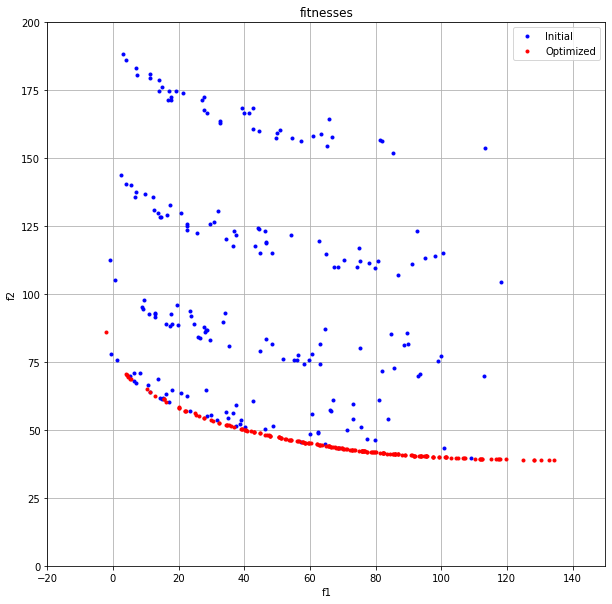

In [22]:
# 目的関数の値を確認
plt.figure(figsize=(10, 10))
fitnesses_init = np.array(
    [list(pop_init[i].fitness.values) for i in range(len(pop_init))]
)
fitnesses = np.array([list(pop[i].fitness.values) for i in range(len(pop))])
# グラフで確認
plt.plot(fitnesses_init[:, 0], fitnesses_init[:, 1], "b.", label="Initial")  # 初期世代
plt.plot(fitnesses[:, 0], fitnesses[:, 1], "r.", label="Optimized")  # 最終世代
plt.legend(loc="upper right")
plt.title("fitnesses")
# 初期の例外値が残っているのでグラフ範囲を指定
plt.xlim(-20, 150)
plt.ylim(0, 200)
plt.xlabel("f1")
plt.ylabel("f2")
plt.grid(True)

#### ハイパーボリュームの計算

In [23]:
# 最終世代のハイパーボリュームを出力
print("Final population hypervolume is %f" % hypervolume(pop, [200.0, 100.0]))

Final population hypervolume is 11025.435241


### 最終世代の設計変数と各適応度をデータフレームで確認

In [24]:
design = pd.DataFrame(pop).rename(
    columns={0: "A", 1: "B", 2: "X", 3: "Y", 4: "Z"}
)  # 設計変数
goal = pd.DataFrame(fitnesses).rename(columns={0: "f1", 1: "f2"})  # 適応度
pd.concat([design, goal], axis=1)

,A,B,X,Y,Z,f1,f2
0,0.006854,0.006078,0,-2,0,-1.999664,85.870771
1,2.379466,2.683718,0,-2,1,50.456801,47.232362
2,3.258788,2.999876,0,-2,1,77.475817,42.032316
3,2.684907,2.678830,0,-2,1,56.539428,45.747485
4,3.839174,2.995691,0,-2,1,93.853703,40.364769
...,...,...,...,...,...,...,...
195,3.126309,2.862916,0,-2,1,70.880385,43.077845
196,2.603392,2.930964,0,-2,1,60.472798,45.024640
197,3.870526,2.996250,0,-2,1,94.833936,40.290726
198,3.950313,2.999691,0,-2,1,97.412479,40.103080


#### テスト: 自作交叉関数の挙動確認

確認する事:
- 個体の成分(A,B,X,Y,Z)に対して、A,B,Zは2点交叉を実行している
- X,Yは交叉発生する場合、両方の成分を入れ替えている(パターンの制約から外れていない)

パターンの制約:
$ 
\begin{align*}
& &(X,Y) \in&  \{(0,-2), (0,-1), (1, 0),(1,1)\}
\end{align*}
$

In [25]:
random.seed(2021)
ind1 = generator(generator_config)
ind2 = generator(generator_config)

In [26]:
# 交叉前の2個体
ind1, ind2

([4.181687511660371, 2.5749072126245625, 1, 1, 0],
 [2.3689541434620214, 0.1912235389545458, 0, -2, 1])

In [27]:
# 交叉後の2個体
toolbox.mate(ind1, ind2)

([4.181687511660371, 0.1912235389545458, 0, -2, 0],
 [2.3689541434620214, 2.5749072126245625, 1, 1, 1])